# Initialize the accelerator

In [1]:
from finn_examples import models
print(list(filter(lambda x: "imagenet" in x, dir(models))))

['_imagenet_top5inds_io_shape_dict', 'mobilenetv1_w4a4_imagenet']


In [2]:
accel = models.mobilenetv1_w4a4_imagenet()

In [3]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal), str(accel.idt)))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal), str(accel.odt)))

Expected input shape and datatype: (1, 224, 224, 3) DataType.UINT8
Expected output shape and datatype: (1, 1, 1, 5) DataType.UINT16


In [4]:
! pip install torchvision

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


# Load the ImageNet validation dataset

In [5]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
import numpy as np
import os

os.environ["IMAGENET_VAL_PATH"]

'/proj/xlabs_t3/users/ml-workspace/datasets/imagenet/raw-images/imagenet_symlink/val'

In [6]:
valdir = os.environ["IMAGENET_VAL_PATH"]
batch_size = 1
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.Lambda(lambda x: np.array(x, dtype=np.uint8))
        ])),
        batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [7]:
test_single_x, test_single_y = val_loader.sampler.data_source.__getitem__(0)

# Classify a single image

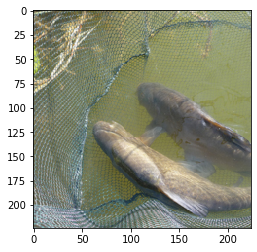

In [8]:
from matplotlib import pyplot as plt

plt.imshow(test_single_x.reshape(224,224,3))
plt.show()

In [9]:
test_single_y

0

In [10]:
accel_in = test_single_x.reshape(accel.ishape_normal)
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 224, 224, 3) and datatype is uint8


In [11]:
accel_out = accel.execute(accel_in)

In [12]:
print("Top-5 classes predicted by the accelerator: " + str(accel_out))

Top-5 classes predicted by the accelerator: [[[[391.  48.   0.  39. 395.]]]]


In [13]:
%%timeit
accel_out = accel.execute(accel_in)

2.71 ms ± 22.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Validate accuracy on entire ImageNet validation set

In [14]:
import numpy as np

batch_size = 1000
accel.batch_size = batch_size
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed), str(accel.oshape_packed)) )
obuf_packed = np.empty_like(accel.obuf_packed_device)
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.Lambda(lambda x: np.array(x, dtype=np.uint8))
        ])),
        batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

Accelerator buffer shapes are (1000, 224, 224, 1, 3) for input, (1000, 1, 1, 1, 10) for output


In [15]:
ok = 0
nok = 0
i = 0
for (imgs, lbls) in val_loader:
    ibuf_normal = imgs.numpy().reshape(accel.ishape_normal)
    exp = lbls.numpy()
    obuf_normal = accel.execute(ibuf_normal)
    obuf_normal = obuf_normal.reshape(batch_size, -1)[:,0]
    ret = np.bincount(obuf_normal.flatten() == exp.flatten())
    nok += ret[0]
    ok += ret[1]
    i += 1
    print("batch %d : total OK %d NOK %d" % (i, ok, nok))

batch 1 : total OK 844 NOK 156
batch 2 : total OK 1589 NOK 411
batch 3 : total OK 2296 NOK 704
batch 4 : total OK 2967 NOK 1033
batch 5 : total OK 3842 NOK 1158
batch 6 : total OK 4622 NOK 1378
batch 7 : total OK 5437 NOK 1563
batch 8 : total OK 6247 NOK 1753
batch 9 : total OK 6949 NOK 2051
batch 10 : total OK 7675 NOK 2325
batch 11 : total OK 8445 NOK 2555
batch 12 : total OK 9172 NOK 2828
batch 13 : total OK 9935 NOK 3065
batch 14 : total OK 10671 NOK 3329
batch 15 : total OK 11444 NOK 3556
batch 16 : total OK 12173 NOK 3827
batch 17 : total OK 13030 NOK 3970
batch 18 : total OK 13765 NOK 4235
batch 19 : total OK 14550 NOK 4450
batch 20 : total OK 15292 NOK 4708
batch 21 : total OK 15973 NOK 5027
batch 22 : total OK 16643 NOK 5357
batch 23 : total OK 17294 NOK 5706
batch 24 : total OK 17922 NOK 6078
batch 25 : total OK 18528 NOK 6472
batch 26 : total OK 19139 NOK 6861
batch 27 : total OK 19806 NOK 7194
batch 28 : total OK 20487 NOK 7513
batch 29 : total OK 21251 NOK 7749
batch 30 : 

In [16]:
total = 50000
acc = 100.0 * ok / (total)
print("Final top-1 accuracy: {}%".format(acc))

Final top-1 accuracy: 70.412%


## More benchmarking

In [17]:
accel.throughput_test()

{'runtime[ms]': 551.5413284301758,
 'throughput[images/s]': 1813.1007568304074,
 'DRAM_in_bandwidth[Mb/s]': 272.92243072416755,
 'DRAM_out_bandwidth[Mb/s]': 0.018131007568304075,
 'fclk[mhz]': 206,
 'batch_size': 1000,
 'fold_input[ms]': 1.0013580322265625e-05,
 'pack_input[ms]': 1.52587890625e-05,
 'copy_input_data_to_device[ms]': 0.07888936996459961,
 'copy_output_data_from_device[ms]': 0.00015473365783691406,
 'unpack_output[ms]': 0.040567874908447266,
 'unfold_output[ms]': 6.4373016357421875e-06}